# Synthetic Data Generation & Empirical Delivery Analysis

## Objective

In this notebook, we generate a synthetic dataset of 10,000 marketplace orders 
across multiple regions to simulate delivery performance variability.

The purpose is to:

- Simulate region-specific delivery time distributions
- Estimate empirical probability of on-time fulfillment (<= 24 hours)
- Establish the statistical foundation for expected value-based decision modeling

This notebook focuses purely on data simulation and distribution analysis.
Economic modeling and decision rule design will follow in the next step.


### Step1: Import Libraries & Set Reproducibility
We import required libraries for:
- Numerical simulation
- Data manipulation
- Visualization
A fixed random seed ensures reproducibility of results.

In [30]:
import numpy as np # Numerical computation
import pandas as pd # Data manipulation
import matplotlib.pyplot as plt # Visualization

np.random.seed(42) # Ensure reproducibility

### Step2: Define Order Volume & Region Distribution
 We simulate 10,000 marketplace orders.
 Region distribution (realistic assumption here):
 - Metro: 50%
 - Tier-2: 30%
 - Remote: 20%
 This purposefully reflects a marketplace skewed toward metro demand.

In [ ]:
N_ORDERS = 10000 # Total number of synthetic orders

# Region probability distribution
region_probs = {
    "Metro": 0.5,
    "Tier-2": 0.3,
    "Remote": 0.2
}

# Assign region to each order using defined probabilities
regions = np.random.choice(
    list(region_probs.keys()),
    size=N_ORDERS,
    p=list(region_probs.values())
)

### Step3: Validate Region Distribution

We verify that the simulated region proportions approximately match 
 the intended 50/30/20 distribution.

In [31]:
# Validate region proportions
region_distribution = pd.Series(regions).value_counts(normalize=True)

region_distribution

Metro     0.500
Tier-2    0.301
Remote    0.199
Name: proportion, dtype: float64

### Step4: Simulate Region-Specific Delivery Times

Each region has distinct delivery characteristics:

Metro:
- Lower average delivery time
- Lower variability

Tier-2:
- Moderate average
- Moderate variability

Remote:
- Higher average
- Higher variability

We simulate delivery time (in hours) using region-specific normal distributions.
Negative values are clipped to maintain realism.

In [32]:

def simulate_delivery_time(region):
    """
    Simulate delivery time (in hours) based on region.
    Uses region-specific mean and standard deviation.
    Ensures delivery time is always positive.
    """
    
    if region == "Metro":
        hours = np.random.normal(loc=18, scale=3)
    elif region == "Tier-2":
        hours = np.random.normal(loc=22, scale=5)
    else:  # Remote
        hours = np.random.normal(loc=30, scale=8)
    
    # Ensure no negative delivery times
    return max(1, hours)


# Generate delivery times for all orders
delivery_hours = np.array([simulate_delivery_time(r) for r in regions])


### Step5: Simulate Additional Order-Level Variables

We simulate supporting operational variables:

- Distance from fulfillment center (positively skewed)
- Warehouse load factor (50%–100%)
- Carrier reliability score (0.7–0.99)

These variables enable future model extensions.

In [33]:

# Distance simulated using gamma distribution (right-skewed)
distance_km = np.random.gamma(shape=2, scale=5, size=N_ORDERS)

# Warehouse load between 50% and 100%
warehouse_load = np.random.uniform(0.5, 1.0, size=N_ORDERS)

# Carrier reliability score between 0.7 and 0.99
carrier_reliability = np.random.uniform(0.7, 0.99, size=N_ORDERS)

# Economic constants
margin = np.full(N_ORDERS, 500)
late_penalty = np.full(N_ORDERS, 800)

### Step6: Construct the Final Dataset

In [34]:
# Combine all variables into a DataFrame
df = pd.DataFrame({
    "region": regions,
    "distance_km": distance_km,
    "warehouse_load": warehouse_load,
    "carrier_reliability": carrier_reliability,
    "actual_delivery_hours": delivery_hours,
    "margin": margin,
    "late_penalty": late_penalty
})

df.head()

,region,distance_km,warehouse_load,carrier_reliability,actual_delivery_hours,margin,late_penalty
0,Tier-2,4.676123,0.670411,0.723800,24.483571,500,800
1,Metro,6.512803,0.784170,0.926671,17.585207,500,800
2,Remote,5.041449,0.888794,0.796954,35.181508,500,800
3,Metro,9.066592,0.857562,0.893168,22.569090,500,800
4,Tier-2,16.606802,0.769922,0.800450,20.829233,500,800


### Step 7: Visualize Delivery Time Distribution

We examine empirical delivery time distributions across regions.

The red dashed line indicates the 24-hour (1-day) promise threshold.


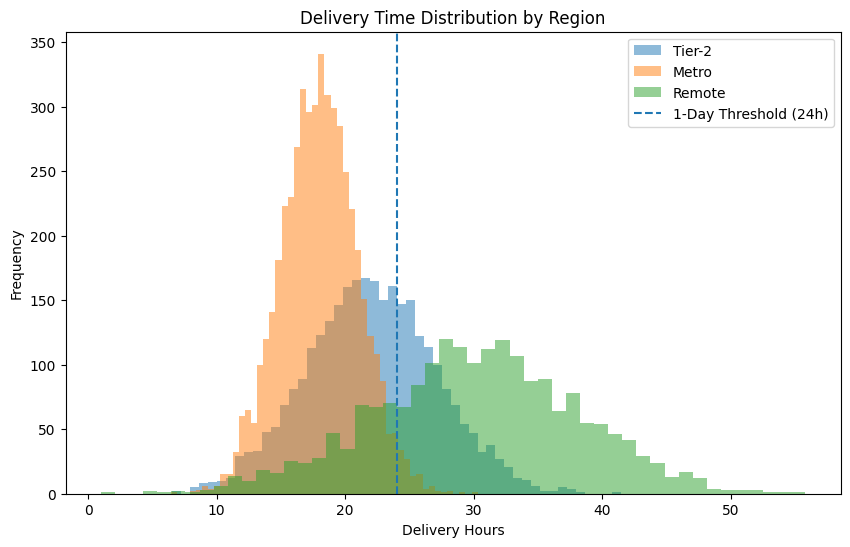

In [ ]:

plt.figure(figsize=(10, 6))

for region in df["region"].unique():
    subset = df[df["region"] == region]
    plt.hist(
        subset["actual_delivery_hours"],
        bins=50,
        alpha=0.5,
        label=region
    )

plt.axvline(24, linestyle='--', label="1-Day Threshold (24h)")
plt.legend()
plt.xlabel("Delivery Hours")
plt.ylabel("Frequency")
plt.title("Delivery Time Distribution by Region")
plt.show()

### Step 8: Estimate Empirical On-Time Probability
We compute:

P(Delivery <= 24 hours | Region)

-This probability directly feeds into expected value modeling.


In [ ]:

PROMISE_HOURS = 24

# Compute empirical on-time probability per region
on_time_probabilities = (
    df.groupby("region")["actual_delivery_hours"]
      .apply(lambda x: np.mean(x <= PROMISE_HOURS))
)

on_time_probabilities

region
Metro     0.977200
Remote    0.220603
Tier-2    0.652492
Name: actual_delivery_hours, dtype: float64

In [ ]:
# Computing the summary statistics

df.groupby("region")["actual_delivery_hours"].agg(["mean", "std", "min", "max"])

,mean,std,min,max
region,,,,
Metro,17.968602,3.016509,6.232799,29.778713
Remote,30.350684,7.899451,1.000000,57.019063
Tier-2,21.906893,5.048720,3.994574,41.263657


In [35]:
# Save dataset for downstream modeling notebooks
df.to_csv("../data/synthetic_orders.csv", index=False)